<a href="https://colab.research.google.com/github/CelaPablo/SOA-EA2/blob/master/HPC/Cela_Pablo_ejercicio_2_GPU_reentrega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

En el siguiente ejercicio, se toma una imagen parametrizada y se la convierte a una con el efecto SEPIA [1, 2].

Para ello, se toman cada pixel de la imagen original y se le aplica siguiente calculo:

<center>NR = 0.393R + 0.769G + 0.189B</center>
<center>NG = 0.349R + 0.686G + 0.168B</center>
<center>NB = 0.272R + 0.534G + 0.131B</center>

Donde R, G y B corresponden a los valores del pixel de la imagen original.
Los nuevos colores calculados, se los compara con 255, y en caso de ser superiores a este, se guarda en dicho color el numero 255 (esto se repite para los 3 colores que conforman el pixel R-G-B).

Con este ejercicio, se pretende entender el funcionamiento basico del Lenguaje Python [3], Google Colab [4,5] y tratamiento de imagenes a bajo nivel.


---
# Armado del ambiente
Se toman la dirección web de una imagen y se la deja disponible en el contexto del cuaderno Colab.


In [ ]:
#@title ## Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://ichef.bbci.co.uk/news/640/cpsprodpb/A694/production/_115644624_gettyimages-984948454.jpg" #@param {type:"string"}


!wget {url_imagen} -O imagen.jpg

---
## Instala el modulo CUDA de Python en el cuaderno.

In [2]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 7.9MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621085 sha256=8960fd367b534a0e8a5561ff7a615d498f1555ea18f3910d63fe99897508ceac
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=d56664a4b247e62290a7d7a05232ae8e282a1fddd93b0c5019303a24e5f4b151
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


# Desarrollo - Ejecución CPU-GPU.

Efecto Sepia.

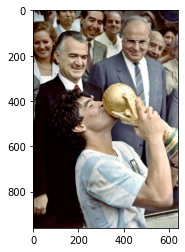

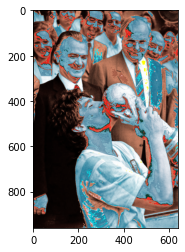

Tiempo en procesar las imagenes: 0.08 [ms]
Tiempo de representacion de las imagenes: 368.595 [ms]
Tiempo Total: 392.517 [ms]


In [15]:
# ------------------------------------------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos --------------
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# ------------------------------------------------------------------------------

try:
  %matplotlib inline
  from datetime import datetime
  import matplotlib.pyplot as plt
  import numpy
  from PIL import Image 
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule
  from matplotlib import pyplot as plt

  tiempo_total = datetime.now()

  # Cargo la imagen. -----------------------------------------------------------
  imagepath = 'imagen.jpg'
  image = Image.open(imagepath)

  # Proporciones de la imagen. ------------------------------------------------- 
  img_alto, img_ancho = image.size 

  # Convierto la imagen comprimida en JPEG/PNG a array. ------------------------
  img_cpu = numpy.asarray(image)
  result_cpu = numpy.empty_like(img_cpu)

  # Reservo memoria en GPU. ----------------------------------------------------
  img_gpu = cuda.mem_alloc(img_cpu.nbytes)
  result_gpu = cuda.mem_alloc(result_cpu.nbytes)

  # GPU - Copio la memoria al GPU. ---------------------------------------------
  cuda.memcpy_htod(img_gpu, img_cpu)
  cuda.memcpy_htod(result_gpu, result_cpu)

  # CPU - Defino la función kernel que ejecutará en GPU.
  module = SourceModule("""
  __global__ void kernel_img(int ancho, int alto, char *img) {
    // Calculo las coordenadas del Thread en dos dimensiones.
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    int idy = threadIdx.y + blockIdx.y*blockDim.y;
    int index = 0;
    float maximo = 255.0;

    // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
    if( idx < ancho && idy < alto )
    {
      index = (idx+(idy*ancho))*3;
      float RI = (float) img[index];
      float GI = (float) img[index+1];
      float BI = (float) img[index+2];

      float nR = (0.939 * RI) + (0.769 * GI) + (0.189 * BI);
      float nG = (0.349 * RI) + (0.686 * GI) + (0.168 * BI);
      float nB = (0.272 * RI) + (0.534 * GI) + (0.131 * BI);

      if(nR > maximo) nR = maximo;
      if(nG > maximo) nG = maximo;
      if(nB > maximo) nB = maximo;

      img[index]   = (char) nR;
      img[index+1] = (char) nG;
      img[index+2] = (char) nB;
    }
  }
  """) 

  # CPU - Genero la función kernel. --------------------------------------------
  kernel = module.get_function("kernel_img")

  tiempo_img = datetime.now()

  # Se calculan las dimensiones de trabajo. ------------------------------------
  dim_hilo_x = 16
  dim_bloque_x = numpy.int((img_ancho+dim_hilo_x-1) / dim_hilo_x)

  dim_hilo_y = 16
  dim_bloque_y = numpy.int((img_alto+dim_hilo_y-1) / dim_hilo_y)

  kernel(numpy.int32(img_ancho), numpy.int32(img_alto), img_gpu, block=(dim_hilo_x, dim_hilo_y, 1), grid=(dim_bloque_x, dim_bloque_y,1))

  tiempo_img = datetime.now() - tiempo_img
  tiempo_representacion = datetime.now()

  # GPU - Copio el resultado desde la memoria GPU. -----------------------------
  cuda.memcpy_dtoh(result_cpu, img_gpu)

  # Muestro la imagen original. ------------------------------------------------
  plt.figure()
  plt.imshow(img_cpu)
  plt.show()

  # Muestro la imagen resultante. ----------------------------------------------
  plt.imshow(result_cpu)
  plt.show()

  tiempo_representacion = datetime.now() - tiempo_representacion 
  tiempo_total = datetime.now() - tiempo_total

  print( "Tiempo en procesar las imagenes:", tiempo_en_ms(tiempo_img), "[ms]")
  print( "Tiempo de representacion de las imagenes:", tiempo_en_ms(tiempo_representacion), "[ms]")
  print( "Tiempo Total:", tiempo_en_ms(tiempo_total), "[ms]")

except ValueError as valerr:
  print(valerr)
except FileNotFoundError:
  print("No se pudo abrir la imagen: ", imagepath)
except ModuleNotFoundError:
  print("Primero deben instalarse las dependencias - Armado del ambiente e instalaciónn de CUDA.")
except: 
  print("Houston we have a problem!")



---
# 4 Tabla de pasos


 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      |  @param       | Lectura de la dirección URL de la imagen a procesar.
CPU      | pip install pycuda    | Instala en el cuaderno los driver de CUDA para Python.
CPU      |  matplotlib inline     | Macro de Colab para mostrar imagenes.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  Image.open()          | Abre el archivo de la imagen a procesar.
CPU      |  numpy.asarray(imagen) | Convierte el formato comprimido JPG a RAW.
CPU      |  numpy.empty_like(()   | Genera el array destino, que tendrá a la imagen resultado. 
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria para la imagen original en GPU.
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria para el resultado GPU.
**GPU**  |  cuda.memcpy_htod()    | Copio los valores en crudo de las imagenes al GPU.
CPU      |  SourceModule()        | Posee el código del kernel.
CPU      |  module.get_function() | Convierte el texto del kernel en funcion de Python.
CPU      |  dim_hilo_x, dim_hilo_y| Calcula las dimensiones para la ejecuciòn de 2D.
**GPU**  |  kernel()              | Ejecuta el kernel en GPU, enviando los parametros.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      | cuda.memcpy_dtoh()     | Copio el resultado desde la memoria GPU al CPU.
CPU      |  plt.imshow            | Muestra la imagen original.
CPU      |  plt.imshow            | Muestra el resultado.
CPU      |  print(...)            | Informa los tiempos de cada funcionalidad.



---
# Conclusión

En este ejercicio se afianzo el funcionamiento del trabajo en paralelo. 

En cuanto a los resultado, el trabajo en paralelo es muchisimo mas rapido y su demora solo se ve afectada por los trabajos en CPU como los de mostrar las imagenes y los tiempos de ejecución.

En promedio, con la ejecución en serie obtuve un resultado de 12374.286 [ms] (tamando 10 ejecuciones). Por otra parte, con la ejecución en paralelo, la nueva imagen se resolvió en un promedio de 345.094 [ms].

Si bien laejecución en paralelo es beneficiosa respecto del tiempo, la ejecución en serie nos provee una calidad final mucho mayor; esto se debe a los calculos aplicados dentro GPU y a las converciones entre los tipos de datos.

## Pasos mas relevantes

1- Lectura de la imagen a procesar.

2- Reservar memoria en GPU (cuda.mem_alloc).

3- Copiar datos en memoria GPU (cuda.memcpy_htod).

4- Definir la función que va a ejecutar el Kernel.

5- Calcular las dimensiones.

6- Ejecutar la funcion en forma paralela (kernel(...)).

6- Copiar datos de la memoria GPU (cuda.memcpy_dtoh).


---
# Bibliografía

[1] Sepia Color: [Wikipedia](https://es.wikipedia.org/wiki/Sepia_(color)

[2] Efecto sepia: [Github](https://abhijitnathwani.github.io/blog/2018/01/08/colortosepia-Image-using-C)

[3] MARKDOWN SYNTAX Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[4] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[5] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

